In [1]:
import numpy as np

import pandas as pd
import pyreadstat    

import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [49]:
def hierarchical_normal(name, shape):
    """
    """
    tilde = pm.Normal(
        f'tilde_{name}', 
        0., 
        1., 
        shape=shape
    )
    mu = pm.Normal(
        f'mu_{name}', 
        0., 
        10.
    )
    tau = pm.HalfCauchy(
        f'tau_{name}', 
        10.
    )
    
    return pm.Deterministic(name, mu + tilde * tau)

In [50]:
polls_df, polls_meta = pyreadstat.read_dta(
    'data\\polls.dta'
)
polls_df = polls_df[polls_df['year'] == 7]
census_df, census_meta = pyreadstat.read_dta(
    'data\\census88.dta'
)

In [51]:
census_df

,female,black,age,edu,state,N
0,0.0,0.0,1.0,1.0,1.0,66177.0
1,0.0,1.0,1.0,1.0,1.0,32465.0
2,1.0,0.0,1.0,1.0,1.0,59778.0
3,1.0,1.0,1.0,1.0,1.0,27416.0
4,0.0,0.0,2.0,1.0,1.0,83032.0
...,...,...,...,...,...,...
3259,1.0,1.0,3.0,4.0,51.0,22.0
3260,0.0,0.0,4.0,4.0,51.0,2441.0
3261,0.0,1.0,4.0,4.0,51.0,5.0
3262,1.0,0.0,4.0,4.0,51.0,2610.0


In [52]:
polls_df

,org,year,survey,bush,state,edu,age,female,black,weight
11351,1,7.0,8,NaN,7.0,3.0,1.0,1.0,0.0,923.0
11352,1,7.0,8,1.0,39.0,4.0,2.0,1.0,0.0,558.0
11353,1,7.0,8,0.0,31.0,2.0,4.0,1.0,0.0,448.0
11354,1,7.0,8,0.0,7.0,3.0,1.0,1.0,0.0,923.0
11355,1,7.0,8,1.0,33.0,2.0,2.0,1.0,0.0,403.0
...,...,...,...,...,...,...,...,...,...,...
13539,1,7.0,8,1.0,3.0,2.0,3.0,1.0,0.0,924.0
13540,1,7.0,8,1.0,5.0,3.0,1.0,1.0,0.0,1012.0
13541,1,7.0,8,0.0,5.0,2.0,2.0,0.0,0.0,1119.0
13542,1,7.0,8,0.0,5.0,3.0,3.0,1.0,1.0,1114.0


In [53]:
agg_polls = polls_df.groupby(
    [
        'state',
        'edu',
        'age',
        'female',
        'black'
    ]
)['bush'].agg(['sum', 'size']).reset_index()


for interaction in [('edu', 'age'), ('edu', 'female'), ('edu', 'black'), ('female', 'black')]:
    
    combined = f'{interaction[0]}_{interaction[1]}'
    
    for data in [agg_polls, census_df]:
        
        
        data[combined] = data[interaction[0]].astype(str) + '_' + data[interaction[1]].astype(str)

    mapper = {
        cat: code+1 for code, cat in enumerate(census_df[combined].unique())
    }
    
    for data in [agg_polls, census_df]:
        
        data[combined] = data[combined].map(mapper)

In [54]:
agg_polls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   state         935 non-null    float64
 1   edu           935 non-null    float64
 2   age           935 non-null    float64
 3   female        935 non-null    float64
 4   black         935 non-null    float64
 5   sum           935 non-null    float64
 6   size          935 non-null    int64  
 7   edu_age       935 non-null    int64  
 8   edu_female    935 non-null    int64  
 9   edu_black     935 non-null    int64  
 10  female_black  935 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 80.5 KB


In [55]:
agg_polls = agg_polls.astype(int)
census_df = census_df.astype(int)

In [56]:
agg_polls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   state         935 non-null    int32
 1   edu           935 non-null    int32
 2   age           935 non-null    int32
 3   female        935 non-null    int32
 4   black         935 non-null    int32
 5   sum           935 non-null    int32
 6   size          935 non-null    int32
 7   edu_age       935 non-null    int32
 8   edu_female    935 non-null    int32
 9   edu_black     935 non-null    int32
 10  female_black  935 non-null    int32
dtypes: int32(11)
memory usage: 40.3 KB


In [57]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 0 to 3263
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   female        3264 non-null   int32
 1   black         3264 non-null   int32
 2   age           3264 non-null   int32
 3   edu           3264 non-null   int32
 4   state         3264 non-null   int32
 5   N             3264 non-null   int32
 6   edu_age       3264 non-null   int32
 7   edu_female    3264 non-null   int32
 8   edu_black     3264 non-null   int32
 9   female_black  3264 non-null   int32
dtypes: int32(10)
memory usage: 127.6 KB


In [58]:
states = census_df['state'].max()
edus = census_df['edu'].max()
ages = census_df['age'].max()


female_black = census_df['female_black'].max()
edu_ages = census_df['edu_age'].max()
edu_female = census_df['edu_female'].max()
edu_black = census_df['edu_black'].max()

In [59]:
with pm.Model() as hier_model:
    
    state_data = pm.Data(
        'state',
        agg_polls['state'].values - 1
    )
    edu_data = pm.Data(
        'edu',
        agg_polls['edu'].values - 1
    )
    age_data = pm.Data(
        'age',
        agg_polls['age'].values - 1
    )
    
    # interactions
    female_black_data = pm.Data(
        'female_black',
        agg_polls['female_black'].values - 1
    )
    edu_ages_data = pm.Data(
        'edu_age',
        agg_polls['edu_age'].values -1
    )
    edu_female_data = pm.Data(
        'edu_female',
        agg_polls['edu_female'].values -1
    )
    edu_black_data = pm.Data(
        'edu_black',
        agg_polls['edu_black'].values -1
    )
    
    n_data = pm.Data(
        'n',
        agg_polls['size'].values
    )
    support_data = pm.Data(
        'support',
        agg_polls['sum'].values
    )
    
    ########## model #################
    
    alpha_state = hierarchical_normal(
        'alpha_state',
        shape=(states,)
    )
    alpha_edu = hierarchical_normal(
        'alpha_edu',
        shape=(edus,)
    )
    alpha_age = hierarchical_normal(
        'alpha_age',
        shape=(ages,)
    )
    
    alpha_edu_age = hierarchical_normal(
        'alpha_edu_age',
        shape=(edu_ages,)
    )
    alpha_edu_black = hierarchical_normal(
        'alpha_edu_black',
        shape=(edu_black,)
    )
    alpha_edu_female = hierarchical_normal(
        'alpha_edu_female',
        shape=(edu_female,)
    )
    
    alpha_female_black = hierarchical_normal(
        'alpha_female_black',
        shape=(female_black,)
    )

    eta = pm.Deterministic(
        'eta',
        pm.math.sigmoid(
            alpha_state[state_data] +
            alpha_edu[edu_data] +
            alpha_age[age_data] +
            alpha_female_black[female_black_data] +
            alpha_edu_age[edu_ages_data] +
            alpha_edu_black[edu_black_data] +
            alpha_edu_female[edu_female_data]
        )
    )
    
    observed = pm.Binomial(
        'observed_support',
        n=n_data,
        p=eta,
        observed=support_data
    )

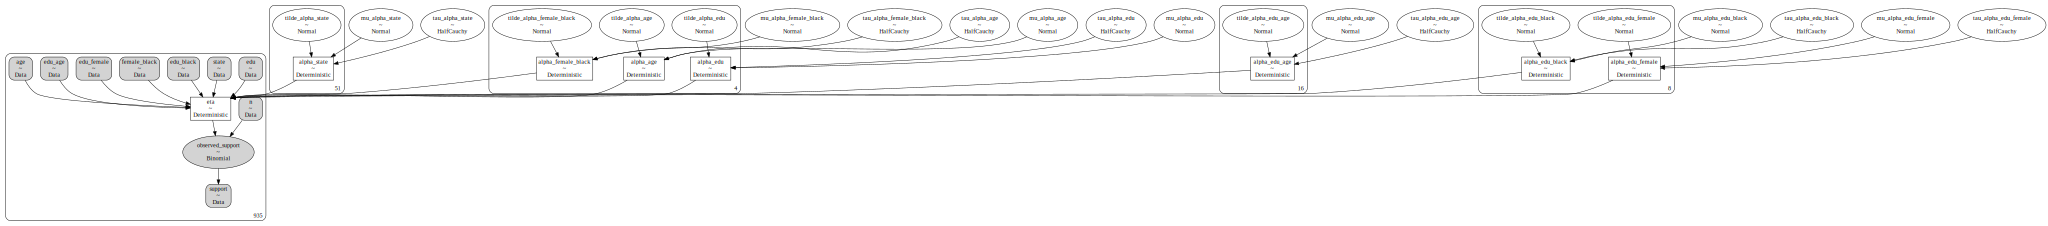

In [60]:
pm.model_to_graphviz(hier_model)

In [61]:
with hier_model:
    
    hier_trace = pm.sample(tune=3000)

C:\Users\valeriob\AppData\Local\Temp/ipykernel_14092/2742647931.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hier_trace = pm.sample(tune=3000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_alpha_female_black, mu_alpha_female_black, tilde_alpha_female_black, tau_alpha_edu_female, mu_alpha_edu_female, tilde_alpha_edu_female, tau_alpha_edu_black, mu_alpha_edu_black, tilde_alpha_edu_black, tau_alpha_edu_age, mu_alpha_edu_age, tilde_alpha_edu_age, tau_alpha_age, mu_alpha_age, tilde_alpha_age, tau_alpha_edu, mu_alpha_edu, tilde_alpha_edu, tau_alpha_state, mu_alpha_state, tilde_alpha_state]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 4116 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Post Stratification

In [62]:
with hier_model:
    
    pm.set_data(
        {
            'state': census_df['state'].values - 1,
            'edu': census_df['edu'].values - 1,
            'female_black': census_df['female_black'].values - 1,
            'age': census_df['age'].values - 1,
            'edu_age': census_df['edu_age'].values - 1,
            'edu_female': census_df['edu_female'].values - 1,
            'edu_black': census_df['edu_black'].values - 1,
            'n': census_df['N'].values,
        }
    )

In [63]:
with hier_model:
    
    pp_trace = pm.sample_posterior_predictive(hier_trace)

In [64]:
pp_columns = [f'support_sample_{sample}' for sample in range(pp_trace['observed_support'].shape[0])]
pp_df = pd.DataFrame(
    pp_trace['observed_support'].T,
    columns=pp_columns
)
pp_df

,support_sample_0,support_sample_1,support_sample_2,support_sample_3,support_sample_4,support_sample_5,support_sample_6,support_sample_7,support_sample_8,support_sample_9,...,support_sample_1990,support_sample_1991,support_sample_1992,support_sample_1993,support_sample_1994,support_sample_1995,support_sample_1996,support_sample_1997,support_sample_1998,support_sample_1999
0,50540,31038,34975,36496,42197,43577,37494,45727,37641,40006,...,42502,47075,33693,46815,35389,54281,26727,45004,39731,43980
1,11122,13608,13629,6536,13907,13739,9127,15860,9075,11097,...,8740,17335,5464,10166,4704,24624,4889,5505,7132,8716
2,43381,24518,26500,30423,37257,36538,31061,40441,36419,31828,...,34521,39664,26010,37721,25541,44156,26088,31733,36297,35174
3,5120,9258,9557,5926,10367,10387,7079,13415,10894,8095,...,7704,10033,4600,8533,2980,17398,2611,3814,5438,3310
4,57767,51505,52247,49963,49582,56193,48477,54094,50979,46862,...,51832,53939,38629,51705,42164,67031,31621,51443,48410,55116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3259,2,2,0,5,4,8,3,4,0,2,...,9,7,7,6,4,2,2,3,3,0
3260,1343,1283,1353,1360,1478,1660,1254,1665,1020,1139,...,1876,1701,1195,1631,1305,1443,1226,957,950,931
3261,0,0,0,0,1,3,0,0,0,2,...,2,4,0,2,0,1,1,0,1,0
3262,1317,1359,1396,1409,1560,1823,1215,1716,1269,1279,...,1895,1613,1098,1561,1273,1497,1366,1037,1055,1034


In [65]:
post_stratified = pd.concat(
    [census_df, pp_df],
    axis=1
)
post_stratified

,female,black,age,edu,state,N,edu_age,edu_female,edu_black,female_black,...,support_sample_1990,support_sample_1991,support_sample_1992,support_sample_1993,support_sample_1994,support_sample_1995,support_sample_1996,support_sample_1997,support_sample_1998,support_sample_1999
0,0,0,1,1,1,66177,1,1,1,1,...,42502,47075,33693,46815,35389,54281,26727,45004,39731,43980
1,0,1,1,1,1,32465,1,1,2,2,...,8740,17335,5464,10166,4704,24624,4889,5505,7132,8716
2,1,0,1,1,1,59778,1,2,1,3,...,34521,39664,26010,37721,25541,44156,26088,31733,36297,35174
3,1,1,1,1,1,27416,1,2,2,4,...,7704,10033,4600,8533,2980,17398,2611,3814,5438,3310
4,0,0,2,1,1,83032,2,1,1,1,...,51832,53939,38629,51705,42164,67031,31621,51443,48410,55116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3259,1,1,3,4,51,22,15,8,8,4,...,9,7,7,6,4,2,2,3,3,0
3260,0,0,4,4,51,2441,16,7,7,1,...,1876,1701,1195,1631,1305,1443,1226,957,950,931
3261,0,1,4,4,51,5,16,7,8,2,...,2,4,0,2,0,1,1,0,1,0
3262,1,0,4,4,51,2610,16,8,7,3,...,1895,1613,1098,1561,1273,1497,1366,1037,1055,1034


In [66]:
post_stratified.to_csv('results\\post_stratified.csv', index=False)
agg_polls.to_csv('results\\agg_polls.csv', index=False)